In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor

# 0. Константное предсказание

In [2]:
df = pd.read_csv('df_train_1.csv')

In [3]:
df['const'] = df['log_trip_duration'].mean()
rmsle = mean_squared_error(df['const'], df['log_trip_duration'], squared=False)
rmsle

0.7957592365411509

# 1. Ridge + 5 признаков
Ridge, добавлены признаки: 
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [4]:
df = pd.read_csv('df_train_1.csv')
df.drop(columns=['id','vendor_id','pickup_datetime'], inplace=True)

In [5]:
categorical = ['store_and_fwd_flag','day_of_week','month','hour']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_res_train = ohe.fit_transform(df[categorical])
#ohe_res_test = ohe.transform(df_test[ohe_columns])
new_columns = ohe.get_feature_names_out(categorical)

df = df.join(pd.DataFrame(ohe_res_train, columns=new_columns)).drop(columns=categorical)
#df_test = df_test.join(pd.DataFrame(ohe_res_test, columns=new_columns)).drop(columns=ohe_columns)

In [6]:
X_train = df.drop(columns='log_trip_duration')
y_train = df['log_trip_duration']

In [7]:
model = Ridge()
cv_baseline = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5, 
    scoring='neg_root_mean_squared_error').mean()

print(-cv_baseline)

0.7737118416981767


# 2. Ridge + haversine + mapgrid + trafic-hours

In [8]:
df = pd.read_csv('df_train_2.csv')
df.drop(columns=['id','vendor_id','pickup_datetime','haversine'], inplace=True)

In [9]:
categorical = ['store_and_fwd_flag','day_of_week','month','hour','pickup_square','dropoff_square']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_res_train = ohe.fit_transform(df[categorical])
#ohe_res_test = ohe.transform(df_test[ohe_columns])
new_columns = ohe.get_feature_names_out(categorical)

df = df.join(pd.DataFrame(ohe_res_train, columns=new_columns)).drop(columns=categorical)
#df_test = df_test.join(pd.DataFrame(ohe_res_test, columns=new_columns)).drop(columns=ohe_columns)

In [10]:
X_train = df.drop(columns='log_trip_duration')
y_train = df['log_trip_duration']

In [11]:
model = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Ridge())
])

cv_baseline = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5, 
    scoring='neg_root_mean_squared_error').mean()

print(-cv_baseline)

0.47756354644297205


# 3.1 Ridge + clean dataset

In [3]:
df = pd.read_csv('df_train_3.csv')

In [4]:
df.drop(columns=['id','pickup_datetime', 'haversine',
                 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude'],
        inplace=True)

In [5]:
categorical = ['store_and_fwd_flag','day_of_week','month','hour','pickup_square','dropoff_square']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_res_train = ohe.fit_transform(df[categorical])
#ohe_res_test = ohe.transform(df_test[ohe_columns])
new_columns = ohe.get_feature_names_out(categorical)

df = df.join(pd.DataFrame(ohe_res_train, columns=new_columns)).drop(columns=categorical)
#df_test = df_test.join(pd.DataFrame(ohe_res_test, columns=new_columns)).drop(columns=ohe_columns)

In [6]:
X_train = df.drop(columns='log_trip_duration')
y_train = df['log_trip_duration']

In [7]:
model = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Ridge())
])

cv_baseline = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5, 
    scoring='neg_root_mean_squared_error').mean()

print(-cv_baseline)

0.41068122628045317


# 3.2 Lasso

In [17]:
model = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Lasso())
])

cv_baseline = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5, 
    scoring='neg_root_mean_squared_error').mean()

print(-cv_baseline)

0.7308523727433732


Получился очень плохой скор, т.к. по умолчанию в Lasso alpha=1, что слишком много для текущей модели

# 4. Ridge подбор alpha

Best alpha = 10.0000


Text(0, 0.5, 'CV score')

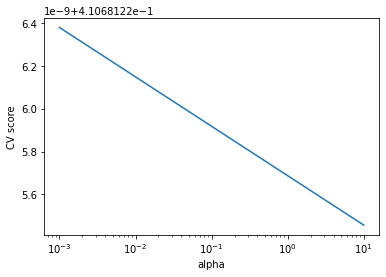

In [8]:
# раскомментировать перед загрузкой

model = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Ridge())
])

alphas = np.logspace(-4, 3, 8)
searcher = GridSearchCV(model, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=5, n_jobs=3)#, n_jobs=-1
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

# 5. Ridge + pickup-dropoff squares

In [2]:
df = pd.read_csv('df_train_5.csv')

In [3]:
df.drop(columns=['id','pickup_datetime', 'haversine',
                 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude'],
        inplace=True)

In [12]:
categorical = [
    'store_and_fwd_flag',
    'day_of_week',
    'month',
    'hour',
    'pickup_square',
    'dropoff_square',
    'p_d_square']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_res_train = ohe.fit_transform(df[categorical])
#ohe_res_test = ohe.transform(df_test[ohe_columns])
new_columns = ohe.get_feature_names_out(categorical)

df = df.join(pd.DataFrame(ohe_res_train, columns=new_columns)).drop(columns=categorical)
#df_test = df_test.join(pd.DataFrame(ohe_res_test, columns=new_columns)).drop(columns=ohe_columns)

In [13]:
X_train = df.drop(columns='log_trip_duration')
y_train = df['log_trip_duration']

In [14]:
model = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Ridge())
])

cv_baseline = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5, 
    scoring='neg_root_mean_squared_error').mean()

print(-cv_baseline)

0.4026051845774113


# 6. feature selection при помощи lasso

In [2]:
df = pd.read_csv('df_train_5.csv')

In [3]:
df.drop(columns=['id','pickup_datetime', 'haversine',
                 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude'],
        inplace=True)

In [4]:
categorical = [
    'store_and_fwd_flag',
    'day_of_week',
    'month',
    'hour',
    'pickup_square',
    'dropoff_square',
    'p_d_square']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_res_train = ohe.fit_transform(df[categorical])
#ohe_res_test = ohe.transform(df_test[ohe_columns])
new_columns = ohe.get_feature_names_out(categorical)

df = df.join(pd.DataFrame(ohe_res_train, columns=new_columns)).drop(columns=categorical)
#df_test = df_test.join(pd.DataFrame(ohe_res_test, columns=new_columns)).drop(columns=ohe_columns)

In [5]:
X_train = df.drop(columns='log_trip_duration')
y_train = df['log_trip_duration']

In [17]:
alphas = [1e-5, 1e-4, 8e-4, 5e-3, 2e-2, 5e-1]
perc_of_zeros = []
for alpha in alphas:
    model = Pipeline(steps=[
        ('scaling', StandardScaler()),
        ('regression', Lasso(alpha=alpha))
    ])

    model.fit(X_train, y_train)
    p = sum(model['regression'].coef_ == 0) / len(model['regression'].coef_)
    perc_of_zeros.append(p)


c:\Users\churi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.503e+04, tolerance: 7.738e+01
  model = cd_fast.enet_coordinate_descent(


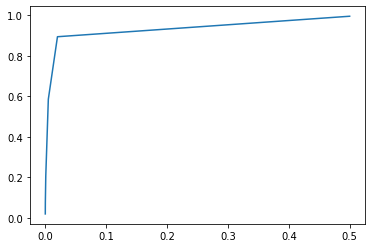

In [18]:
plt.plot(alphas, perc_of_zeros)

In [ ]:
# вместо 5e-1 попробовать 8e-2

In [19]:
perc_of_zeros

[0.020202020202020204,
 0.07575757575757576,
 0.20707070707070707,
 0.5858585858585859,
 0.8939393939393939,
 0.9949494949494949]

In [14]:
#8e-4 -> .207
#5e-3 -> .5858

True

# -1. Submission

In [2]:
df_train = pd.read_csv('df_train_5.csv')
df_test = pd.read_csv('df_test_5.csv')

In [3]:
df_train.drop(columns=['id','pickup_datetime', 'haversine',
                 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude'],
        inplace=True)
df_test.drop(columns=['id','pickup_datetime', 'haversine',
                 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude'],
        inplace=True)

In [4]:
categorical = [
    'store_and_fwd_flag',
    'day_of_week',
    'month',
    'hour',
    'pickup_square',
    'dropoff_square',
    'p_d_square']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_res_train = ohe.fit_transform(df_train[categorical])
ohe_res_test = ohe.transform(df_test[categorical])
new_columns = ohe.get_feature_names_out(categorical)

df_train = df_train.join(pd.DataFrame(ohe_res_train, columns=new_columns)).drop(columns=categorical)
df_test = df_test.join(pd.DataFrame(ohe_res_test, columns=new_columns)).drop(columns=categorical)

In [5]:
X_train = df_train.drop(columns='log_trip_duration')
y_train = df_train['log_trip_duration']

In [6]:
model = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', XGBRegressor())
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('regression',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=4, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [7]:
pred = model.predict(df_test)

In [8]:
np.expm1(pred)

array([ 695.5368,  692.1328,  391.0741, ..., 1463.3538, 2097.3843,
       1055.1492], dtype=float32)

In [9]:
df_sub = pd.read_csv('df_test_5.csv')

In [10]:
df_sub['trip_duration'] = np.expm1(pred)

In [11]:
df_sub1 = df_sub[['id','trip_duration']]

In [13]:
df_sub1.to_csv('subm_xgb.csv', index=False)